In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import numba
from numba import njit,jit
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [3]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 2.69 s


In [4]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0))
By = np.transpose(a.twbox[0].by,(2,1,0))
Bz = np.transpose(a.twbox[0].bz,(2,1,0))

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

time: 2 ms


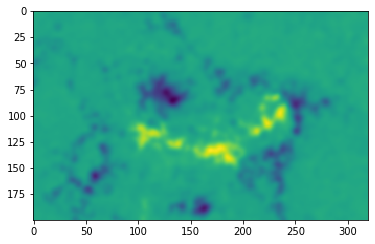

time: 215 ms


In [5]:
plt.imshow(Bz[350:670,200:400,0].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)

In [6]:
np.mean(np.abs((Bx)))

11.779769

time: 1.16 s


In [7]:
vec = np.array([1.01,2.01,5.01])
vec[vec<=0]=1e-9
vec[vec>=Bx.shape]=(np.array(Bx.shape)-1e-9)[vec>=Bx.shape]

time: 2.01 ms


In [8]:
Bx_gpu.shape

(0,)

time: 3.01 ms


In [9]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy

traceFunc_file = open("TraceBline.cu", "rt")
traceFunc =SourceModule(traceFunc_file.read())
print('compiling kernel')
TraceAllBline = traceFunc.get_function("TraceAllBline")
TraceBline_test = traceFunc.get_function("TraceBline_test")

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = gpuarray.to_gpu(Bx.astype(np.float32))
    By_gpu = gpuarray.to_gpu(By.astype(np.float32))
    Bz_gpu = gpuarray.to_gpu(Bz.astype(np.float32))

compiling kernel
transfering B-field to GPU
time: 7.53 s


In [27]:
# shape of B
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape

interp_ratio=0.3
x_range = [350,670]
y_range = [200,400]
#x_range = [587,588]
#y_range = [301,302]
x_i = np.linspace(*x_range, np.uint32(interp_ratio*(x_range[1]-x_range[0])))
y_i = np.linspace(*y_range, np.uint32(interp_ratio*(y_range[1]-y_range[0])))
x_arr,y_arr = np.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten().astype(np.float32)
y_inp = y_arr.flatten().astype(np.float32)
z_inp = np.zeros_like(x_inp).astype(np.float32)

#z_inp[:] = 23.0

x_out = np.zeros_like(x_inp).astype(np.float32)
y_out = np.zeros_like(x_inp).astype(np.float32)
z_out = np.zeros_like(x_inp).astype(np.float32)

flag_out = np.zeros_like(x_inp).astype(np.int32)
step_line_len = np.zeros_like(x_inp).astype(np.ulonglong)

s_len = np.float32([0.25])
N=np.ulonglong([x_inp.shape[0]])

blck = (32,32,1)
grid_a = 2**(np.int(np.log2(np.sqrt(N/1024))))
grd = (grid_a,int(np.ceil(N/grid_a/1024)))

blck=(128,1,1)
grd = (64,1)

# chuck everything

time: 5 ms


In [28]:
y_arr

array([[200.        , 200.        , 200.        , ..., 200.        ,
        200.        , 200.        ],
       [203.38983051, 203.38983051, 203.38983051, ..., 203.38983051,
        203.38983051, 203.38983051],
       [206.77966102, 206.77966102, 206.77966102, ..., 206.77966102,
        206.77966102, 206.77966102],
       ...,
       [393.22033898, 393.22033898, 393.22033898, ..., 393.22033898,
        393.22033898, 393.22033898],
       [396.61016949, 396.61016949, 396.61016949, ..., 396.61016949,
        396.61016949, 396.61016949],
       [400.        , 400.        , 400.        , ..., 400.        ,
        400.        , 400.        ]])

time: 4.01 ms


In [29]:
BshapeN = gpuarray.to_gpu(BshapeN)
x_inp = gpuarray.to_gpu(x_inp)
y_inp = gpuarray.to_gpu(y_inp)
z_inp = gpuarray.to_gpu(z_inp)

x_out = gpuarray.to_gpu(x_out)
y_out = gpuarray.to_gpu(y_out)
z_out = gpuarray.to_gpu(z_out)

s_len    = gpuarray.to_gpu(s_len)
flag_out = gpuarray.to_gpu(flag_out)
N        = gpuarray.to_gpu(N)

step_line_len = gpuarray.to_gpu(step_line_len)


time: 33 ms


In [30]:
TraceAllBline(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
             x_inp,y_inp,z_inp,
             x_out,y_out,z_out,
             s_len,flag_out,N,step_line_len,
             block=blck,grid=grd)

pycuda.driver.Context.synchronize()

time: 138 ms


In [36]:
flag_out.get()

array([42, 42, 42, ..., 42, 42, 42])

time: 21 ms


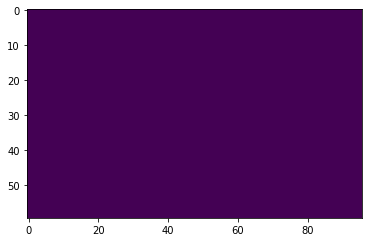

time: 229 ms


In [32]:
plt.imshow(flag_out.get().reshape(xy_shape))

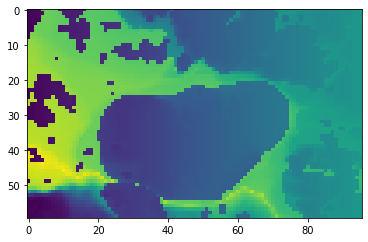

time: 147 ms


In [37]:
plt.imshow(x_out.get().reshape(xy_shape))

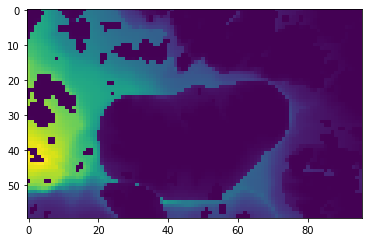

time: 149 ms


In [35]:
plt.imshow(step_line_len.get().reshape(xy_shape))

In [17]:
#from mpl_toolkits import mplot3d

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot(xx,yy,zz)

time: 1 ms


In [18]:
flag_out

array([42, 42, 42, ...,  0,  0,  0])

time: 4 ms


In [19]:
starting_point = np.array([400.5,250.5,0.0]).astype(np.float32)
ending_point = np.array([400.5,250.5,0.0]).astype(np.float32)
xx = np.zeros(1000).astype(np.float32)
yy = np.zeros(1000).astype(np.float32)
zz = np.zeros(1000).astype(np.float32)

starting_point = gpuarray.to_gpu(starting_point)
ending_point = gpuarray.to_gpu(ending_point)
xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)
zz = gpuarray.to_gpu(zz)

pycuda.driver.Context.synchronize()

time: 3.98 ms


In [20]:
TraceBline_test(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
             starting_point,ending_point,
             s_len,flag_out,N,step_line_len,
             xx,yy,zz,
             block=(1,1,1))

time: 1 ms


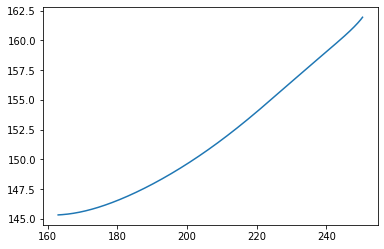

time: 166 ms


In [21]:
plt.plot(xx.get(),yy.get())

In [22]:
zz = np.zeros(1000).astype(np.float32)


zz.shape

(1000,)

time: 3 ms


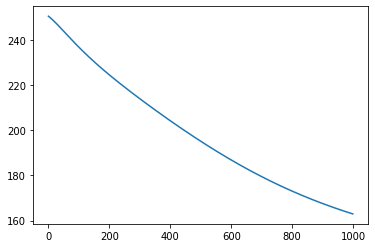

time: 133 ms


In [23]:
plt.plot(xx.get())

In [24]:
xx.get()

array([250.40343, 250.30371, 250.20082, 250.09473, 249.9854 , 249.87343,
       249.75943, 249.64346, 249.52559, 249.40585, 249.28488, 249.16273,
       249.03943, 248.91495, 248.78922, 248.66241, 248.53455, 248.40564,
       248.2757 , 248.14485, 248.01318, 247.88072, 247.74731, 247.61299,
       247.47786, 247.34198, 247.20538, 247.0681 , 246.93018, 246.79163,
       246.65244, 246.51265, 246.37231, 246.23148, 246.09016, 245.94843,
       245.80627, 245.66373, 245.5208 , 245.37753, 245.23396, 245.09012,
       244.94604, 244.80174, 244.65723, 244.51253, 244.36768, 244.22272,
       244.07764, 243.93246, 243.78722, 243.64192, 243.49663, 243.35132,
       243.206  , 243.06068, 242.9154 , 242.77022, 242.62509, 242.48004,
       242.33508, 242.19025, 242.04555, 241.90097, 241.75652, 241.61223,
       241.46811, 241.32419, 241.18044, 241.03685, 240.89345, 240.75026,
       240.60732, 240.46457, 240.32204, 240.17972, 240.03764, 239.89581,
       239.75421, 239.61285, 239.47176, 239.33092, 

time: 13 ms


In [25]:
str([1,1,2])

'[1, 1, 2]'

time: 2.98 ms
